In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def load_results(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def prepare_data(results):
    data = []
    for classifier, transformations in results.items():
        original_scores = transformations['original']['test']['fine_parent']
        for attack_type, params in transformations.items():
            for attack_value, metrics in params.items():
                for class_name, class_metrics in metrics['fine_parent'].items():
                    row = {
                        'classifier': classifier,
                        'class': class_name,
                        'attack_type': attack_type,
                        'attack_value': attack_value if attack_type != 'original' else 'test',
                        'f1': class_metrics['f1'],
                        'precision': class_metrics['precision'],
                        'recall': class_metrics['recall'],
                        'accuracy': class_metrics['accuracy']
                    }
                    data.append(row)
    return pd.DataFrame(data)

In [3]:
def generate_latex_table(results):
    latex_table = r"\begin{table}[ht]\centering\begin{tabular}{lcccc}\hline"
    latex_table += "\nClassifier & Precision & Recall & F1-score & Accuracy \\\\ \hline\n"
    
    for classifier, transformations in results.items():
        classifier_data = transformations['original']['test']['parent']
        
        precision = classifier_data['precision']
        recall = classifier_data['recall']
        f1_score = classifier_data['f1']
        accuracy = classifier_data['accuracy']
        
        latex_table += f"{classifier} & {float(precision):.3f} & {float(recall):.3f} & {float(f1_score):.3f} & {float(accuracy):.3f} \\\\ \n"

    latex_table += r"\hline\n\end{tabular}"
    latex_table += r"\caption{Classifier performance on the test set}\label{tab:test_results}\end{table}"
    
    print(latex_table)

In [4]:
def plot_scores(data, score='f1', save=False, save_dir=None, plot_by='class'):
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})

    classes = data['class'].unique()
    classifiers = data['classifier'].unique()
    attack_types = ['low_pass', 'high_pass', 'decrease_sr']

    # Define custom colors and markers for classifiers
    palette = sns.color_palette("Set2", n_colors=3)
    markers = ['o', 's', '^']

    # Create the save directory if it does not exist
    if save and save_dir:
        os.makedirs(save_dir, exist_ok=True)

    if plot_by == 'class':
        # Plot by class
        for class_name in classes:
            class_data = data[data['class'] == class_name]
            
            # Plot low_pass and high_pass together
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

            # Determine common y-axis limits for low_pass and high_pass
            low_pass_data = class_data[class_data['attack_type'] == 'low_pass'][score]
            high_pass_data = class_data[class_data['attack_type'] == 'high_pass'][score]
            y_min = min(low_pass_data.min(), high_pass_data.min())
            y_max = max(low_pass_data.max(), high_pass_data.max())
            y_min_adjusted = y_min - 0.05
            y_max_adjusted = y_max + 0.05

            for i, attack in enumerate(['low_pass', 'high_pass']):
                ax = ax1 if i == 0 else ax2
                attack_data = class_data[class_data['attack_type'] == attack]

                for j, classifier in enumerate(attack_data['classifier'].unique()):
                    classifier_data = attack_data[attack_data['classifier'] == classifier]
                    classifier_data = classifier_data.sort_values('attack_value')
                    x = pd.to_numeric(classifier_data['attack_value'])
                    if classifier == 'svc':
                        classifier = 'svm'
                    ax.plot(x, classifier_data[score], marker=markers[j], markersize=6, label=classifier, color=palette[j])

                ax.set_title(f'{attack.replace("_", " ").title()} Filter', fontsize=14)
                ax.set_xlabel('Cutoff Frequency (Hz)', fontsize=12)
                if i == 0:
                    ax.set_ylabel(f'{score.upper()} Score', fontsize=12)
                ax.legend(title='Classifier', title_fontsize='12', fontsize='10')
                ax.grid(True, linestyle='--', alpha=0.7)
                ax.set_ylim(y_min_adjusted, y_max_adjusted)

            if class_name == 'lastfm':
                class_name = 'msd'
            plt.suptitle(f'{class_name}: {score.upper()} Score vs Low Pass and High Pass Filters', fontsize=16)
            plt.tight_layout()
            if save:
                fig_path = os.path.join(save_dir, f'{class_name}_low_high_pass_{score}.pdf')
                plt.savefig(fig_path, format='pdf', dpi=300, bbox_inches='tight')
            else:
                plt.show()
            plt.close()

    elif plot_by == 'classifier':
        # Plot by classifier
        for classifier in classifiers:
            classifier_data = data[data['classifier'] == classifier]
            if classifier == 'svc':
                classifier = 'svm'

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

            # Determine common y-axis limits for low_pass and high_pass
            low_pass_data = classifier_data[classifier_data['attack_type'] == 'low_pass'][score]
            high_pass_data = classifier_data[classifier_data['attack_type'] == 'high_pass'][score]
            y_min = min(low_pass_data.min(), high_pass_data.min())
            y_max = max(low_pass_data.max(), high_pass_data.max())
            y_min_adjusted = y_min - 0.05
            y_max_adjusted = y_max + 0.05

            for i, attack in enumerate(['low_pass', 'high_pass']):
                ax = ax1 if i == 0 else ax2
                attack_data = classifier_data[classifier_data['attack_type'] == attack]

                for j, class_name in enumerate(attack_data['class'].unique()):
                    class_data = attack_data[attack_data['class'] == class_name]
                    class_data = class_data.sort_values('attack_value')
                    x = pd.to_numeric(class_data['attack_value'])
                    ax.plot(x, class_data[score], marker=markers[j], markersize=6, label=class_name, color=palette[j])

                ax.set_title(f'{attack.replace("_", " ").title()} Filter', fontsize=14)
                ax.set_xlabel('Cutoff Frequency (Hz)', fontsize=12)
                if i == 0:
                    ax.set_ylabel(f'{score.upper()} Score', fontsize=12)
                ax.legend(title='Class', title_fontsize='12', fontsize='10')
                ax.grid(True, linestyle='--', alpha=0.7)
                ax.set_ylim(y_min_adjusted, y_max_adjusted)

            plt.suptitle(f'{classifier.upper()}: {score.upper()} Score vs Low Pass and High Pass Filters', fontsize=16)
            plt.tight_layout()
            if save:
                fig_path = os.path.join(save_dir, f'{classifier}_low_high_pass_{score}.pdf')
                plt.savefig(fig_path, format='pdf', dpi=300, bbox_inches='tight')
            else:
                plt.show()
            plt.close()

    # Plot other attack types (e.g., decrease_sr) separately
    for attack_type in ['decrease_sr']:
        for item in (classes if plot_by == 'class' else classifiers):
            item_data = data[data['class'] == item] if plot_by == 'class' else data[data['classifier'] == item]
            item_label = item if plot_by == 'class' else ('svm' if item == 'svc' else item)

            plt.figure(figsize=(10, 6))
            attack_data = item_data[item_data['attack_type'] == attack_type]

            for j, sub_item in enumerate(attack_data['classifier'].unique() if plot_by == 'class' else attack_data['class'].unique()):
                sub_data = attack_data[attack_data['classifier'] == sub_item] if plot_by == 'class' else attack_data[attack_data['class'] == sub_item]
                sub_data = sub_data.sort_values('attack_value')
                x = pd.to_numeric(sub_data['attack_value'], errors='coerce')
                plt.plot(x, sub_data[score], marker=markers[j], markersize=6, label=sub_item, color=palette[j])

            if item_label == 'lastfm':
                item_label = 'msd'
            plt.title(f'{item_label}: {score.upper()} Score vs {attack_type.replace("_", " ").title()}', fontsize=16)
            plt.xlabel('Sample Rate (Hz)' if attack_type == 'decrease_sr' else f'{attack_type.replace("_", " ").title()} Value', fontsize=12)
            plt.ylabel(f'{score.upper()} Score', fontsize=12)
            plt.legend(title='Classifier' if plot_by == 'class' else 'Class', title_fontsize='12', fontsize='10')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            if save:
                fig_path = os.path.join(save_dir, f'{item_label}_{attack_type}_{score}.pdf')
                plt.savefig(fig_path, format='pdf', dpi=300, bbox_inches='tight')
            else:
                plt.show()
            plt.close()

\begin{table}[ht]\centering\begin{tabular}{lcccc}\hline
Classifier & Precision & Recall & F1-score & Accuracy \\ \hline
svc & 0.979 & 0.979 & 0.979 & 0.979 \\ 
rf & 0.959 & 0.959 & 0.958 & 0.959 \\ 
knn & 0.955 & 0.954 & 0.954 & 0.954 \\ 
\hline\n\end{tabular}\caption{Classifier performance on the test set}\label{tab:test_results}\end{table}


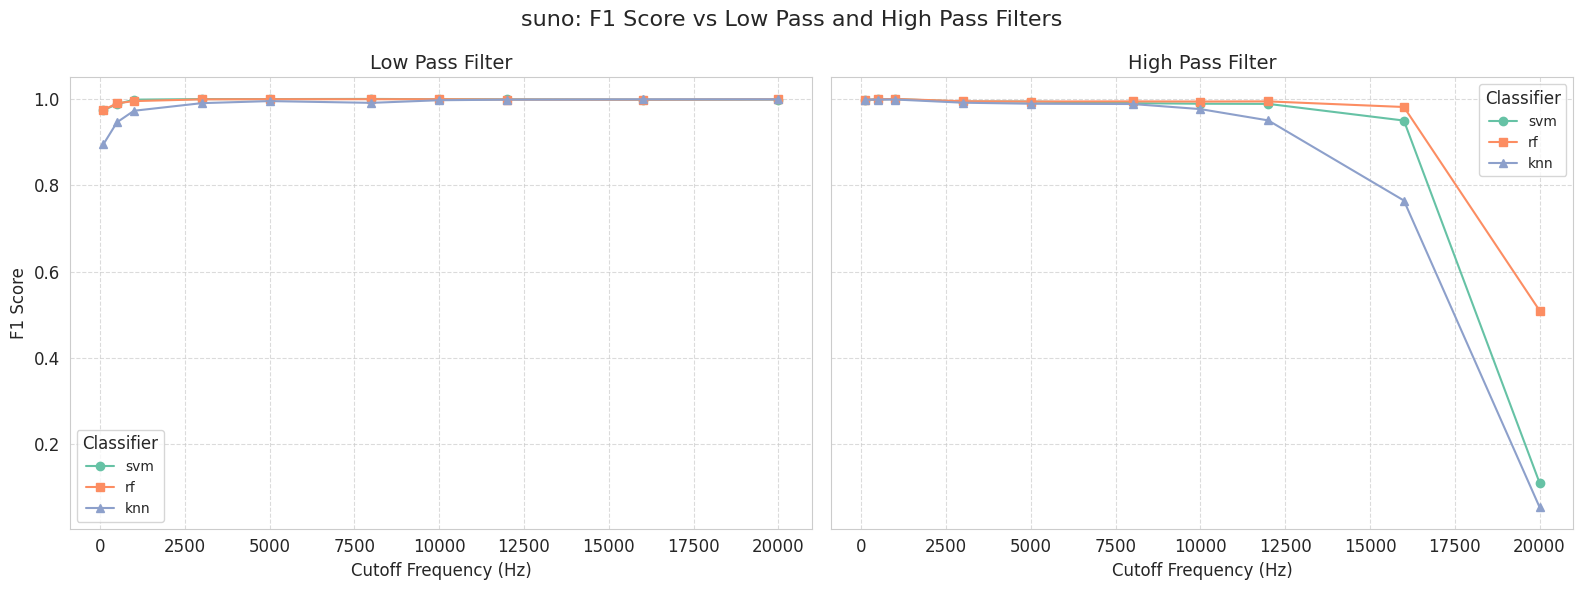

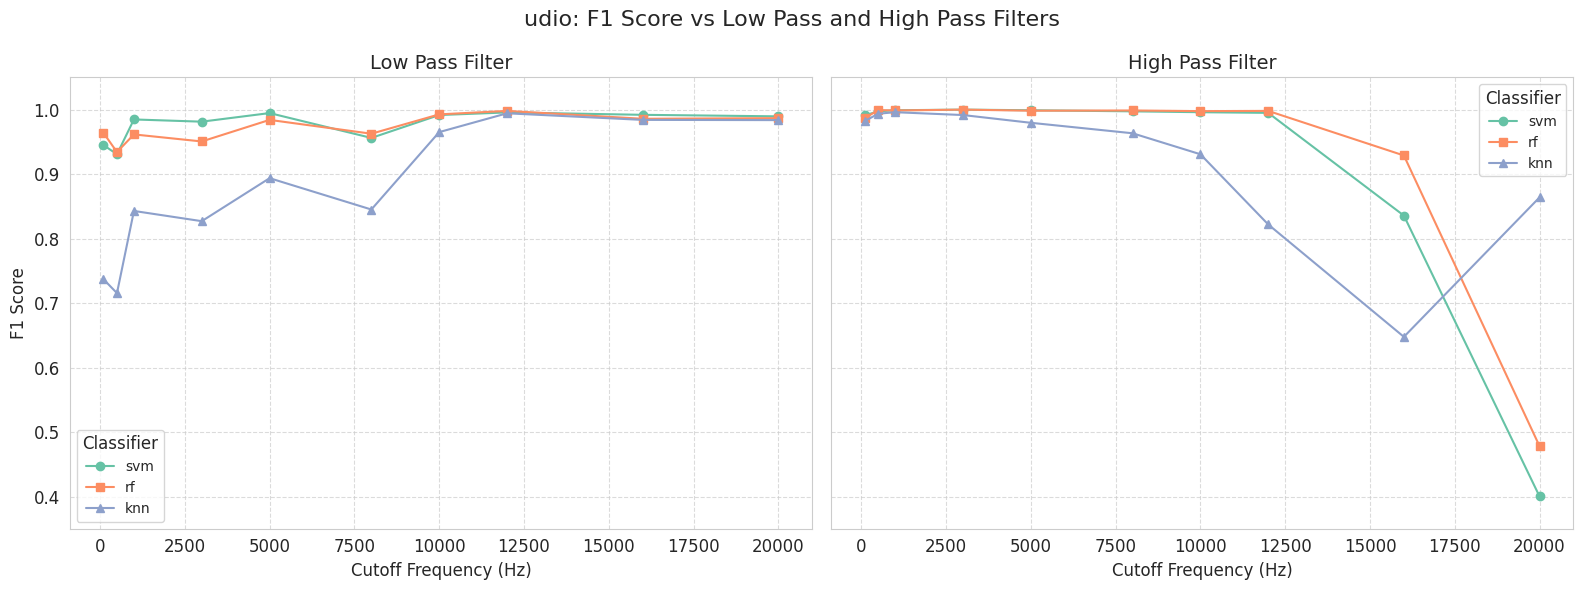

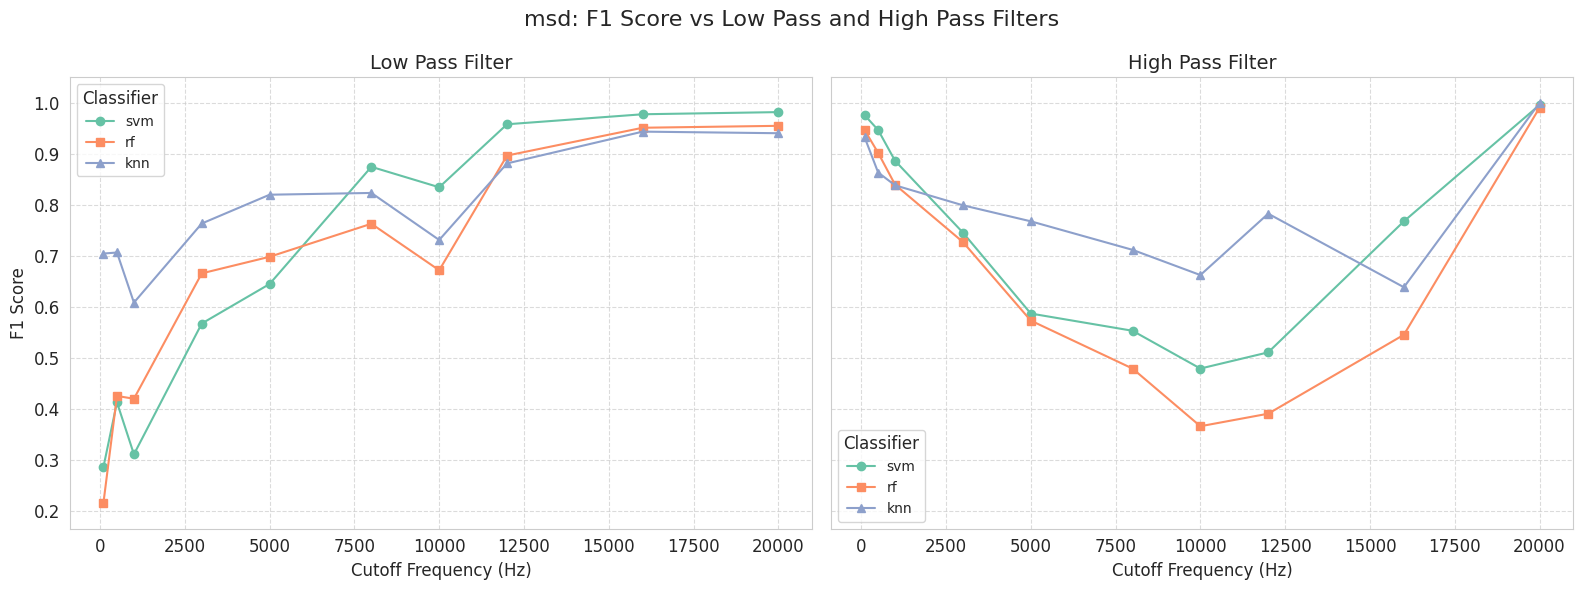

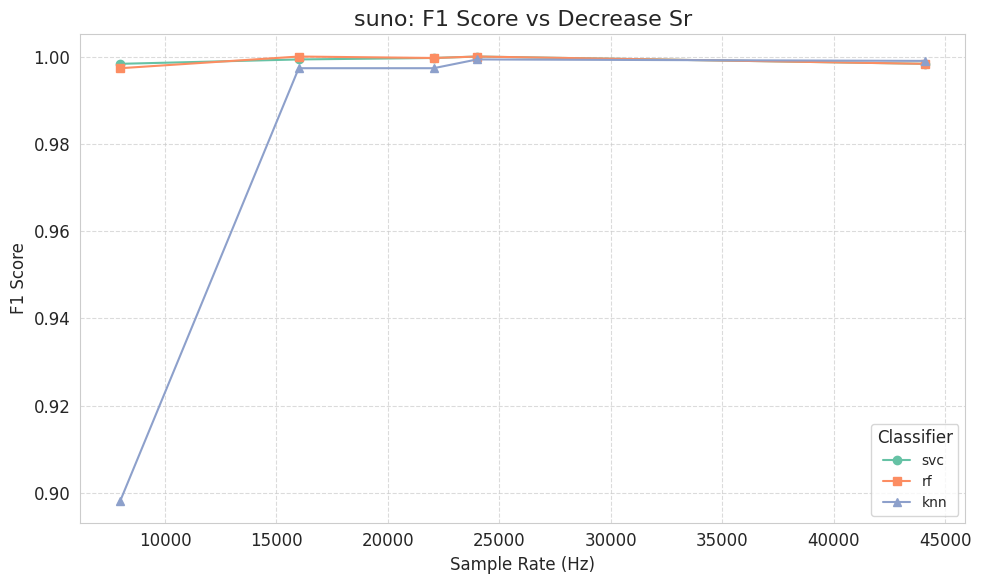

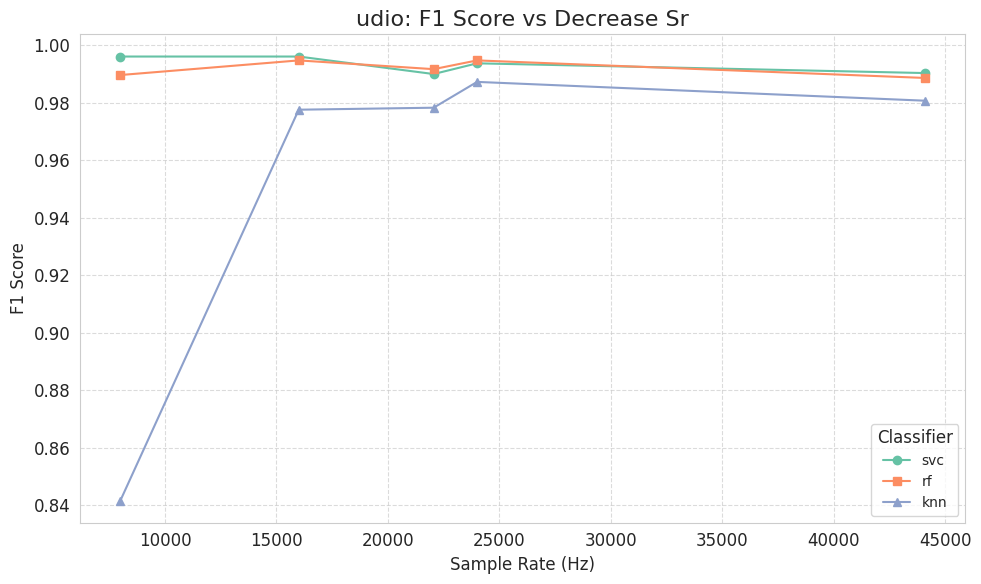

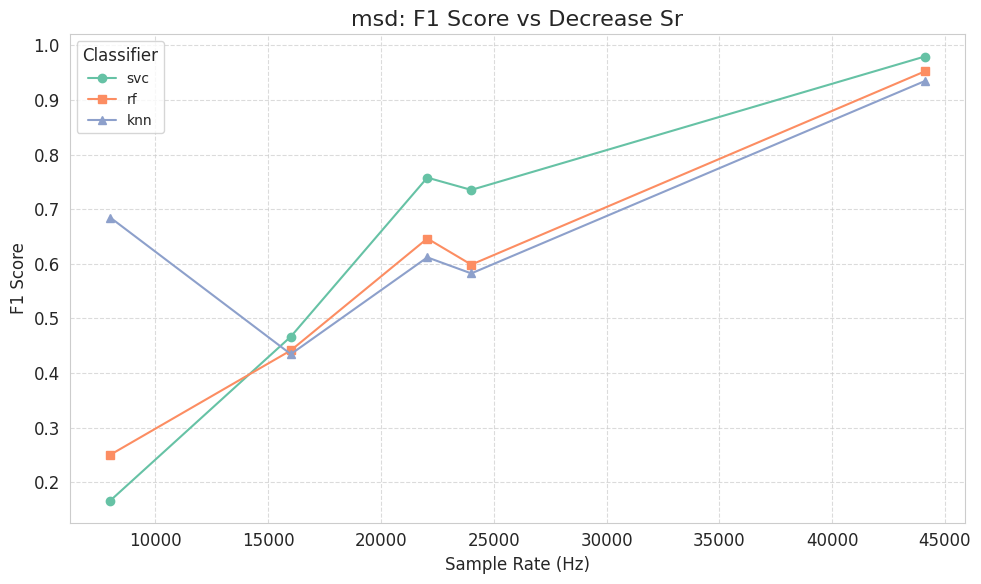

In [5]:
results = load_results('evaluation_results_hierarchical_test.pkl')
data = prepare_data(results)
generate_latex_table(results)
plot_scores(data, 'f1', save=False, save_dir='figures/robustness_test', plot_by='class')